# Text classification (multiclass) 

# Table of Content

* [Goal](#obj)
* [Importing packages and loading data](#imp)
* [Exploratory Data Analysis (EDA) and Feature Engineering](#eda)
* [Text Preprocessing](#pre)
* [Multi-Classification models](#ml)
    * [Spliting the data: train and test](#sp)
    * [Models](#m)
* [Comparison of model performance](#sum)
* [Model Evaluation](#ev)
    * [Precision, Recall, F1-score](#f1)
    * [Confusion Matrix](#cm)
* [Predictions](#pred)

<a id='obj'></a>
## Goal:<br>
Classify consumer complaints into predefined categories.<br><br>
Credit reporting, repair, or other<br>
Debt collection<br>
Consumer Loan<br>
Mortgage<br>

Classification algorithms: Linear Support Vector Machine (LinearSVM), Random Forest, Multinomial Naive Bayes and Logistic Regression.<br><br>

<a id='imp'></a>
## Importing packages and loading data

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# loading data
df=pd.read_csv("complaints.csv", low_memory=False)
df.shape

(3562204, 18)

We have more than 3 million instances (rows) and 18 features (columns).

<a id='eda'></a>
## Exploratory Data Analysis (EDA) and Feature Engineering

In [3]:
df.head(2).T # Columns are shown in rows for easy reading

,0,1
Date received,2023-04-14,2023-04-14
Product,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o..."
Sub-product,Credit reporting,Credit reporting
Issue,Improper use of your report,Problem with a credit reporting company's inve...
Sub-issue,Reporting company used your report improperly,Their investigation did not fix an error on yo...
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,Experian Information Solutions Inc.,Experian Information Solutions Inc.
State,TX,CA
ZIP code,75208,92886


The dataset contains features that are not necessary to solve our multi-classification problem. For this text classification problem, we are going to build another dataframe that contains ‘Product’ and ‘Consumer complaint narrative’ (renamed as 'Consumer_complaint').

In [4]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# select only relevant products
df1 = df1[df['Product'].isin(['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Consumer Loan', 'Mortgage'])] 

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

df1.shape

(952623, 2)

In [5]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

26.7

From more than 3 million complaints, there are about 950,000 cases with text (~ 26% of the original dataset is not null). 


In [6]:
pd.DataFrame(df1.Product.unique()).values

array([['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Debt collection'],
       ['Mortgage'],
       ['Consumer Loan']], dtype=object)

There are 18 different classes or categories (target). However; it is observed that some classes are contained in others. For instance, ‘Credit card’ and ‘Prepaid card’ are contained in ‘Credit card or prepaid card’ category. Now, imagine there is a new complaint about Credit card and we want to classify it. The algorithm can either classify this complaint as 'Credit card' or 'Credit card or prepaid' and it would be correct. Nevertheless, this would affect model performance. In order to avoid this problem, the names of some categories were renamed.

In [7]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [8]:
# Renaming categories
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [9]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Mortgage
2,Debt collection
3,Consumer Loan


The number of classes were reduced. <br><br>Now we need to represent each class as a number, so as our predictive model can better understand the different categories.

In [10]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
3006235,"Credit reporting, repair, or other",I received a copy of my credit report and ther...,0
765779,"Credit reporting, repair, or other",Fedloan still reporting on credit report even ...,0
3402677,Mortgage,Out of the blue my 9 : year mortgage payment w...,1
3159555,"Credit reporting, repair, or other",Im submitting a complaint to you today to info...,0
2937836,"Credit reporting, repair, or other",To whomever can help me receive results. \nI h...,0


The bar chart below shows the number of complaints per category. It can be observed that The bar chart below shows the number of complaints per category. It can be observed that most of customer complaints are due to:
* credit reporting, credit repair
* debt collection 
* mortgage 

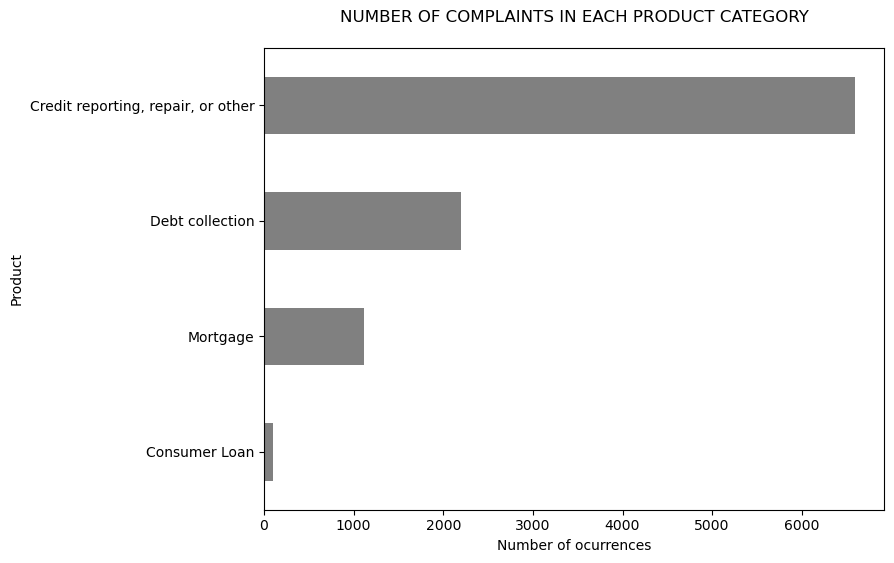

In [11]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

<a id='pre'></a>
## Text Preprocessing

The text needs to be transformed to vectors so as the algorithms will be able make predictions. In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight to evaluate __how important a word is to a document in a collection of documents__.

After removing __punctuation__ and __lower casing__ the words, importance of a word is determined in terms of its frequency.

### “Term Frequency – Inverse Document Frequency 

__TF-IDF__ is the product of the __TF__ and __IDF__ scores of the term.<br><br> $$\text{TF-IDF}=\frac{\text{TF}}{\text{IDF}}$$<br>

__Term Frequency :__ This summarizes how often a given word appears within a document.

$$\text{TF} = \frac{\text{Number of times the term appears in the doc}}{\text{Total number of words in the doc}}$$<br><br>
__Inverse Document Frequency:__ This downscales words that appear a lot across documents. A term has a high IDF score if it appears in a few documents. Conversely, if the term is very common among documents (i.e., “the”, “a”, “is”), the term would have a low IDF score.<br>

$$\text{IDF} = \ln\left(\frac{\text{Number of docs}}{\text{Number docs the term appears in}} \right)$$<br>

TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents. The higher the TFIDF score, the rarer the term is. For instance, in a Mortgage complaint the word _mortgage_ would be mentioned fairly often. However, if we look at other complaints, _mortgage_ probably would not show up in many of them. We can infer that _mortgage_ is most probably an important word in Mortgage complaints as compared to the other products. Therefore, _mortgage_ would have a high TF-IDF score for Mortgage complaints.

TfidfVectorizer class can be initialized with the following parameters:
* __min_df__: remove the words from the vocabulary which have occurred in less than ‘min_df’ number of files.
* __max_df__: remove the words from the vocabulary which have occurred in more than _‘max_df’ * total number of files in corpus_.
* __sublinear_tf__: set to True to scale the term frequency in logarithmic scale.
* __stop_words__: remove the predefined stop words in 'english'.
* __use_idf__: weight factor must use inverse document frequency.
* __ngram_range__: (1, 2) to indicate that unigrams and bigrams will be considered.

In [12]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 24978 features (TF-IDF score of unigrams and bigrams)


In [13]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Consumer Loan:
  * Most Correlated Unigrams are: santander, car, vehicle
  * Most Correlated Bigrams are: stop payment, capital auto, santander consumer

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: section, mortgage, debt
  * Most Correlated Bigrams are: consumer reporting, 15 1681, 1681 section

==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: trying collect, collect debt, collection agency

==> Mortgage:
  * Most Correlated Unigrams are: modification, escrow, mortgage
  * Most Correlated Bigrams are: loan modification, wells fargo, mortgage company


<a id='ml'></a>
## Multi-Classification models

The classification models evaluated are: 
* Random Forest
* Linear Support Vector Machine
* Multinomial Naive Bayes 
* Logistic Regression.

<a id='sp'></a>
### Spliting the data into train and test sets
The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [14]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

<a id='m'></a>
### Models

In [15]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

<a id='sum'></a>
## Comparison of model performance

The best mean acuracy was obtained with LinearSVC.

In [16]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8960,0.001969
LogisticRegression,0.8912,0.004132
MultinomialNB,0.8645,0.007770
RandomForestClassifier,0.6600,0.001173


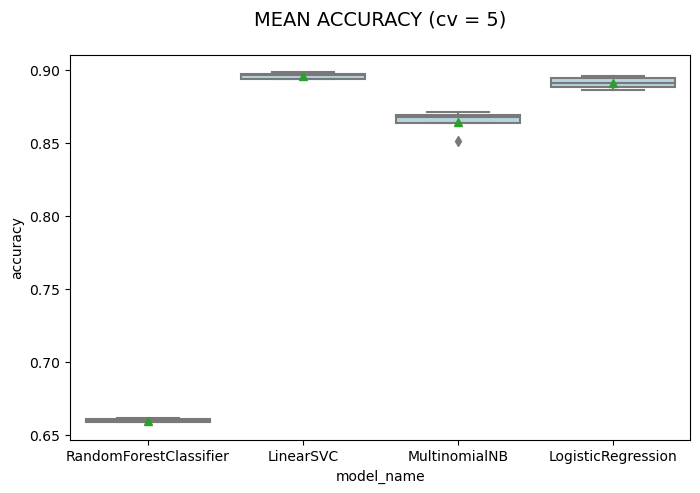

In [17]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
        
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

<a id='ev'></a>
## Model Evaluation

In [18]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<a id='m'></a>
### Precision, Recall, F1-score

In [19]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS

                                    precision    recall  f1-score   support

Credit reporting, repair, or other       0.92      0.95      0.93      1644
                          Mortgage       0.90      0.94      0.92       282
                   Debt collection       0.86      0.77      0.81       555
                     Consumer Loan       0.50      0.05      0.10        19

                          accuracy                           0.90      2500
                         macro avg       0.79      0.68      0.69      2500
                      weighted avg       0.90      0.90      0.90      2500



It is possible to observe that the classes with more support (number of occurrences) tend to have a better f1-cscore. This is because the algorithm was trained with more data.<br><br>
The classes that can be classified with more precision are __‘Mortgage’__, __‘Credit reporting, repair, or other’__, and __‘Debt collection’__.

<a id='cm'></a>
### Confusion Matrix

A Confusion Matrix is a table which rows represent the actual class and columns represents the predicted class.<br><br>
If we had a perfect model that always classifies correctly a new complaint, then the confusion matrix would have values in the diagonal only (where predicted label = actual label).

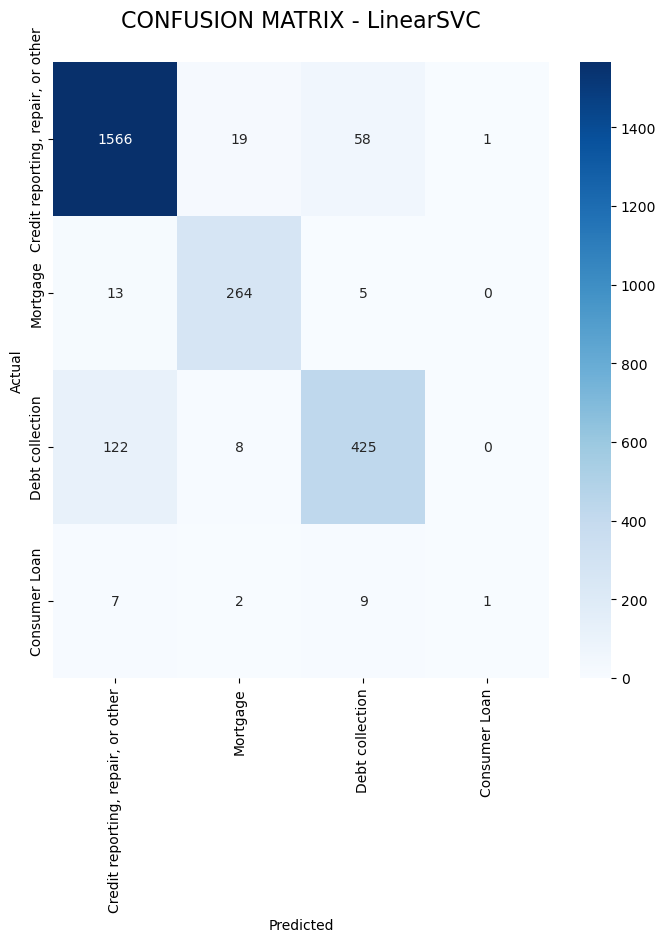

In [20]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In general, the confusion matrix looks good (clear diagonal that represents correct classifications). Nevertheless, there are cases were the complaint was classified in a wrong class.

#### Misclassified complaints
Let’s have a look at the cases that were wrongly classified.

In [21]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 
                                                                'Consumer_complaint']])
      print('')

'Debt collection' predicted as 'Credit reporting, repair, or other' : 122 examples.


,Product,Consumer_complaint
476725,Debt collection,"On XX/XX/2020, I emailed the following to Ad A..."
1974420,Debt collection,This account was placed with XXXX XXXX XXXX XX...
1514973,Debt collection,I 've just chosen the largest umbrella issue t...
1291075,Debt collection,On Thursday XX/XX/XXXX a suspicious charge to ...
3510356,Debt collection,"On XX/XX/2022, USCB AMERICA added a derogatory..."
...,...,...
66242,Debt collection,"XX/XX/2022, I previously notified you that I a..."
1271584,Debt collection,I was a victim of violent crime. I am not resp...
2837444,Debt collection,I recently pulled a copy of my credit report a...
1851761,Debt collection,Transworld continues to hurt my credit by sayi...



'Credit reporting, repair, or other' predicted as 'Debt collection' : 58 examples.


,Product,Consumer_complaint
1008602,"Credit reporting, repair, or other",I have ask CRA to provide verification of this...
2669059,"Credit reporting, repair, or other","Greetings, XXXX and Capital One Violated my co..."
1262410,"Credit reporting, repair, or other",XXXX has sent I the consumer several letters s...
2962304,"Credit reporting, repair, or other",XXXX XXXX made the statement in their respons...
418984,"Credit reporting, repair, or other",I have XXXX XXXX accounts on my credit report ...
3024191,"Credit reporting, repair, or other",the company XXXX who in charge the work out wo...
1452216,"Credit reporting, repair, or other",I called to make Equifax on X/XX/2017 to get a...
2131545,"Credit reporting, repair, or other","On Friday, XX/XX/2019, I retrieved a copy of m..."
840040,"Credit reporting, repair, or other",I was going through my credit report and I saw...
238861,"Credit reporting, repair, or other",This is illegal I will take that XXXX XXXX dol...


#### Most correlated terms with each category

In [22]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Consumer Loan':
  * Top unigrams: vehicle, car, 99, loan
  * Top bigrams: capital auto, santander consumer, repeatedly asked, took loan

==> 'Credit reporting, repair, or other':
  * Top unigrams: experian, transunion, equifax, report
  * Top bigrams: debt debt, xxxx xxxx, xxxx equifax, payments time

==> 'Debt collection':
  * Top unigrams: debt, collection, associates, collect
  * Top bigrams: reporting negative, validate inaccurate, sold debt, appeared credit

==> 'Mortgage':
  * Top unigrams: mortgage, escrow, ocwen, home
  * Top bigrams: mortgage company, wells fargo, mortgage xxxx, escrow account


<a id='pred'></a>
## Predictions

Now let's make a few predictions on unseen data.<br>

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

Classification on new complaint.

In [24]:
new_complaint_1 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_1])))

['Credit reporting, repair, or other']


In [26]:
df3=df1[df1['Consumer_complaint'] == new_complaint_1]
df3

,Product,Consumer_complaint
785303,"Credit reporting, credit repair services, or o...",Equifax exposed my personal information withou...
